In [101]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import time
import numpy as np
import tensorflow as tf
from tensorflow.models.rnn.ptb import reader
from tensorflow.python.ops import rnn, rnn_cell
import matplotlib.pyplot as plt
%matplotlib inline

## RNN

### A. LSTM LANGUAGE MODEL

##### CODE FROM TUTORIAL (BIG DATA UNIVERSITY)

In [19]:
# LOAD DATA (PENN TREEBANK)

!wget http://www.fit.vutbr.cz/~imikolov/rnnlm/simple-examples.tgz 
!tar xzf simple-examples.tgz -C /Users/jacobsw/Desktop/CODER/TENSORFLOW/DATA/

--2017-01-01 15:59:10--  http://www.fit.vutbr.cz/~imikolov/rnnlm/simple-examples.tgz
Resolving www.fit.vutbr.cz... 2001:67c:1220:809::93e5:917, 147.229.9.23
Connecting to www.fit.vutbr.cz|2001:67c:1220:809::93e5:917|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 34869662 (33M) [application/x-gtar]
Saving to: ‘simple-examples.tgz’

simple-examples.tgz 100%[===================>]  33.25M   777KB/s    in 53s     

2017-01-01 16:00:04 (640 KB/s) - ‘simple-examples.tgz’ saved [34869662/34869662]



In [37]:
# SET HYPERPARAMETERS

#Initial weight scale
init_scale = 0.1
#Initial learning rate
learning_rate = 1.0
#Maximum permissible norm for the gradient (For gradient clipping -- another measure against Exploding Gradients)
max_grad_norm = 5
#The number of layers in our model
num_layers = 2
#The total number of recurrence steps, also known as the number of layers when our RNN is "unfolded"
num_steps = 20
#The number of processing units (neurons) in the hidden layers
hidden_size = 200
#The maximum number of epochs trained with the initial learning rate
max_epoch = 4
#The total number of epochs in training
max_max_epoch = 13
#The probability for keeping data in the Dropout Layer (This is an optimization, but is outside our scope for this notebook!)
#At 1, we ignore the Dropout Layer wrapping.
keep_prob = 1
#The decay for the learning rate
decay = 0.5
#The size for each batch of data
batch_size = 20
#The size of our vocabulary
vocab_size = 10000
#Training flag to separate training from testing
is_training = 1
#Data directory for our dataset
data_dir = "/Users/jacobsw/Desktop/CODER/TENSORFLOW/DATA/simple-examples/data/"

In [88]:
class PTBModel(object):

    def __init__(self, is_training):
        ######################################
        # Setting parameters for ease of use #
        ######################################
        self.batch_size = batch_size
        self.num_steps = num_steps
        size = hidden_size
        self.vocab_size = vocab_size
        
        ###############################################################################
        # Creating placeholders for our input data and expected outputs (target data) #
        ###############################################################################
        self._input_data = tf.placeholder(tf.int32, [batch_size, num_steps])
        self._targets = tf.placeholder(tf.int32, [batch_size, num_steps])

        ##########################################################################
        # Creating the LSTM cell structure and connect it with the RNN structure #
        ##########################################################################
        # Create the LSTM unit. Size is the same as the size of our hidden layer, and no bias is added to the Forget Gate
        # This creates only the structure for the LSTM and has to be associated with a RNN unit still
        lstm_cell = tf.nn.rnn_cell.BasicLSTMCell(size, forget_bias=0.0, state_is_tuple=False)
        
        # Unless you changed keep_prob, this won't actually execute -- this is a dropout wrapper for our LSTM unit
        # This is an optimization of the LSTM output, but is not needed at all
        if is_training and keep_prob < 1:
            lstm_cell = tf.nn.rnn_cell.DropoutWrapper(lstm_cell, output_keep_prob=keep_prob)
        
        # By taking in the LSTM cells as parameters, the MultiRNNCell function junctions the LSTM units to the RNN units
        cell = tf.nn.rnn_cell.MultiRNNCell([lstm_cell] * num_layers, state_is_tuple=False)
        
        # Define the initial state, i.e., the model state for the very first data point
        self._initial_state = cell.zero_state(batch_size, tf.float32)

        ####################################################################
        # Creating the word embeddings and pointing them to the input data #
        ####################################################################
        with tf.device("/cpu:0"):
            # Create the embeddings for our input data
            embedding = tf.get_variable("embedding", [vocab_size, size])
            # Define where to get the data for our embeddings from
            inputs = tf.nn.embedding_lookup(embedding, self._input_data)

        # Unless you changed keep_prob, this won't actually execute -- this is a dropout addition for our inputs
        # This is an optimization of the input processing and is not needed at all
        if is_training and keep_prob < 1:
            inputs = tf.nn.dropout(inputs, keep_prob)

        ############################################
        # Creating the input structure for our RNN #
        ############################################
        # The input structure is fed from the embeddings, which are filled in by the input data
        inputs = [tf.squeeze(input_, [1]) for input_ in tf.split(1, num_steps, inputs)]
        
        ####################################################################################################
        # Instanciating our RNN model and retrieving the structure for returning the outputs and the state #
        ####################################################################################################
        outputs, state = rnn.rnn(cell, inputs, initial_state=self._initial_state)

        #########################################################################
        # Creating a logistic unit to return the probability of the output word #
        #########################################################################
        output = tf.reshape(tf.concat(1, outputs), [-1, size])
        softmax_w = tf.get_variable("softmax_w", [size, vocab_size])
        softmax_b = tf.get_variable("softmax_b", [vocab_size])
        logits = tf.matmul(output, softmax_w) + softmax_b

        #########################################################################
        # Defining the loss and cost functions for the model's learning to work #
        #########################################################################
        loss = tf.nn.seq2seq.sequence_loss_by_example([logits], [tf.reshape(self._targets, [-1])],
                                                      [tf.ones([batch_size * num_steps])])
        self._cost = cost = tf.reduce_sum(loss) / batch_size

        # Store the final state
        self._final_state = state

        #Everything after this point is relevant only for training
        if not is_training:
            return

        #################################################
        # Creating the Training Operation for our Model #
        #################################################
        # Create a variable for the learning rate
        self._lr = tf.Variable(0.0, trainable=False)
        # Get all TensorFlow variables marked as "trainable" (i.e. all of them except _lr, which we just created)
        tvars = tf.trainable_variables()
        # Define the gradient clipping threshold
        grads, _ = tf.clip_by_global_norm(tf.gradients(cost, tvars), max_grad_norm)
        # Create the gradient descent optimizer with our learning rate
        optimizer = tf.train.GradientDescentOptimizer(self.lr)
        # Create the training TensorFlow Operation through our optimizer
        self._train_op = optimizer.apply_gradients(zip(grads, tvars))

    # Helper functions for our LSTM RNN class

    # Assign the learning rate for this model
    def assign_lr(self, session, lr_value):
        session.run(tf.assign(self.lr, lr_value))

    # Returns the input data for this model at a point in time
    @property
    def input_data(self):
        return self._input_data

    # Returns the targets for this model at a point in time
    @property
    def targets(self):
        return self._targets

    # Returns the initial state for this model
    @property
    def initial_state(self):
        return self._initial_state

    # Returns the defined Cost
    @property
    def cost(self):
        return self._cost

    # Returns the final state for this model
    @property
    def final_state(self):
        return self._final_state

    # Returns the current learning rate for this model
    @property
    def lr(self):
        return self._lr

    # Returns the training operation defined for this model
    @property
    def train_op(self):
        return self._train_op

In [89]:
# OLD reader.ptb_iterator is deprecated and removed.

def ptb_iterator(raw_data, batch_size, num_steps):
    raw_data = np.array(raw_data, dtype=np.int32)

    data_len = len(raw_data)
    batch_len = data_len // batch_size
    data = np.zeros([batch_size, batch_len], dtype=np.int32)
    for i in range(batch_size):
        data[i] = raw_data[batch_len * i:batch_len * (i + 1)]

    epoch_size = (batch_len - 1) // num_steps

    if epoch_size == 0:
        raise ValueError("epoch_size == 0, decrease batch_size or num_steps")

    for i in range(epoch_size):
        x = data[:, i*num_steps:(i+1)*num_steps]
        y = data[:, i*num_steps+1:(i+1)*num_steps+1]
        yield (x, y)

In [90]:
##########################################################################################################################
# run_epoch takes as parameters the current session, the model instance, the data to be fed, and the operation to be run #
##########################################################################################################################
def run_epoch(session, m, data, eval_op, verbose=False):

    #Define the epoch size based on the length of the data, batch size and the number of steps
    epoch_size = ((len(data) // m.batch_size) - 1) // m.num_steps
    start_time = time.time()
    costs = 0.0
    iters = 0
    state = m.initial_state.eval()
    
    #For each step and data point
#     for step, (x, y) in enumerate(reader.ptb_iterator(data, m.batch_size,
#                                                     m.num_steps)):
    for step, (x, y) in enumerate(ptb_iterator(data, m.batch_size,
                                                    m.num_steps)):
        
        #Evaluate and return cost, state by running cost, final_state and the function passed as parameter
        cost, state, _ = session.run([m.cost, m.final_state, eval_op],
                                     {m.input_data: x,
                                      m.targets: y,
                                      m.initial_state: state})
        
        #Add returned cost to costs (which keeps track of the total costs for this epoch)
        costs += cost
        
        #Add number of steps to iteration counter
        iters += m.num_steps

        if verbose and step % (epoch_size // 10) == 10:
            print("%.3f perplexity: %.3f speed: %.0f wps" % (step * 1.0 / epoch_size, np.exp(costs / iters),
              iters * m.batch_size / (time.time() - start_time)))

    # Returns the Perplexity rating for us to keep track of how the model is evolving
    return np.exp(costs / iters)


In [91]:
# Reads the data and separates it into training data, validation data and testing data
raw_data = reader.ptb_raw_data(data_dir)
train_data, valid_data, test_data, _ = raw_data

#Initializes the Execution Graph and the Session
with tf.Graph().as_default(), tf.Session() as session:
    initializer = tf.random_uniform_initializer(-init_scale,
                                            init_scale)
    
    # Instantiates the model for training
    with tf.variable_scope("model", reuse=None, initializer=initializer):
        m = PTBModel(is_training=True)
        
    # Reuses the trained parameters for the validation and testing models
    # They are different instances but use the same variables for weights and biases, they just don't change when data is input
    with tf.variable_scope("model", reuse=True, initializer=initializer):
        mvalid = PTBModel(is_training=False)
        mtest = PTBModel(is_training=False)

    #Initialize all variables
    tf.global_variables_initializer().run()

    for i in range(max_max_epoch):
        # Define the decay for this epoch
        lr_decay = decay ** max(i - max_epoch, 0.0)
        
        # Set the decayed learning rate as the learning rate for this epoch
        m.assign_lr(session, learning_rate * lr_decay)

        print("Epoch %d : Learning rate: %.3f" % (i + 1, session.run(m.lr)))
        
        # Run the loop for this epoch in the training model
        train_perplexity = run_epoch(session, m, train_data, m.train_op,
                                   verbose=True)
        print("Epoch %d : Train Perplexity: %.3f" % (i + 1, train_perplexity))
        
        # Run the loop for this epoch in the validation model
        valid_perplexity = run_epoch(session, mvalid, valid_data, tf.no_op())
        print("Epoch %d : Valid Perplexity: %.3f" % (i + 1, valid_perplexity))
    
    # Run the loop in the testing model to see how effective was our training
    test_perplexity = run_epoch(session, mtest, test_data, tf.no_op())
    
    print("Test Perplexity: %.3f" % test_perplexity)

Epoch 1 : Learning rate: 1.000
0.004 perplexity: 5725.722 speed: 1326 wps
0.104 perplexity: 855.605 speed: 1755 wps
0.204 perplexity: 633.067 speed: 1732 wps
0.304 perplexity: 511.406 speed: 1770 wps
0.404 perplexity: 440.481 speed: 1797 wps
0.504 perplexity: 394.260 speed: 1789 wps
0.604 perplexity: 354.727 speed: 1782 wps
0.703 perplexity: 327.548 speed: 1791 wps
0.803 perplexity: 306.208 speed: 1800 wps
0.903 perplexity: 286.498 speed: 1810 wps
Epoch 1 : Train Perplexity: 271.746
Epoch 1 : Valid Perplexity: 181.218
Epoch 2 : Learning rate: 1.000
0.004 perplexity: 214.239 speed: 1816 wps
0.104 perplexity: 151.318 speed: 1848 wps
0.204 perplexity: 158.296 speed: 1786 wps
0.304 perplexity: 153.225 speed: 1751 wps
0.404 perplexity: 150.338 speed: 1766 wps
0.504 perplexity: 147.750 speed: 1765 wps
0.604 perplexity: 143.100 speed: 1766 wps
0.703 perplexity: 140.890 speed: 1778 wps
0.803 perplexity: 138.810 speed: 1789 wps
0.903 perplexity: 135.050 speed: 1797 wps
Epoch 2 : Train Perplexit

### B. LSTM SEQUENCE CLASSIFICATION

In [93]:
# LOAD DATA

from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('.', one_hot=True)

Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Extracting ./train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Extracting ./train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting ./t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting ./t10k-labels-idx1-ubyte.gz


Train Sizes:  (55000, 784) (55000, 10)
Test Sizes:  (10000, 784) (10000, 10)
Sample:



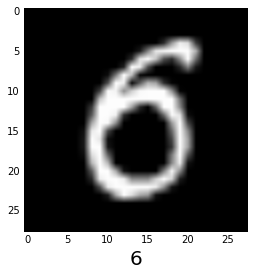

Iter 1280, Minibatch Loss = 1.876079, Training Accuracy = 0.34375
Iter 2560, Minibatch Loss = 1.412820, Training Accuracy = 0.50000
Iter 3840, Minibatch Loss = 1.217277, Training Accuracy = 0.57031
Iter 5120, Minibatch Loss = 0.979868, Training Accuracy = 0.65625
Iter 6400, Minibatch Loss = 0.665566, Training Accuracy = 0.78906
Iter 7680, Minibatch Loss = 0.615495, Training Accuracy = 0.80469
Iter 8960, Minibatch Loss = 0.462367, Training Accuracy = 0.88281
Iter 10240, Minibatch Loss = 0.389916, Training Accuracy = 0.86719
Iter 11520, Minibatch Loss = 0.237537, Training Accuracy = 0.91406
Iter 12800, Minibatch Loss = 0.366488, Training Accuracy = 0.86719
Iter 14080, Minibatch Loss = 0.418528, Training Accuracy = 0.88281
Iter 15360, Minibatch Loss = 0.283164, Training Accuracy = 0.91406
Iter 16640, Minibatch Loss = 0.215019, Training Accuracy = 0.93750
Iter 17920, Minibatch Loss = 0.296394, Training Accuracy = 0.88281
Iter 19200, Minibatch Loss = 0.239417, Training Accuracy = 0.91406
It

In [123]:
# DATA INFO

trainX, trainY, testX, testY = mnist.train.images, mnist.train.labels, mnist.test.images, mnist.test.labels
print('Train Sizes: ', trainX.shape, trainY.shape)
print('Test Sizes: ', testX.shape, testY.shape)
print

print("Sample:\n")
plt.imshow(trainX[0].reshape([28,28]), cmap='gray')
plt.xlabel(np.argmax(trainY[0]), fontsize=20)
plt.show()

# PREPARE PARAMETERS

n_input = 28 # width
n_steps = 28 # height
n_hidden = 128
n_classes = 10
learning_rate = .001
training_iters = 100000
batch_size = 128
display_step = 10

# BUILD GRAPH

x = tf.placeholder(tf.float32, shape=[None, n_steps, n_input], name='x')
y = tf.placeholder(tf.float32, shape=[None, n_classes], name='y')
weights = tf.Variable(tf.random_normal([n_hidden, n_classes]))
biases = tf.Variable(tf.random_normal([n_classes]))

def LSTM(x, weights, biases): # x = [batch_size, n_steps, n_input].
    x = tf.transpose(x, [1,0,2])
    x = tf.reshape(x, [-1,n_input]) # reshape to (n_steps*batch_size, n_input)
    x = tf.split(split_dim=0, num_split=n_steps, value=x) # get a list of n_steps tensors of shape (batch_size, n_input).
    lstm_cell = rnn_cell.BasicLSTMCell(n_hidden, forget_bias=1.)
    outputs, states = rnn.rnn(cell=lstm_cell, inputs=x, dtype=tf.float32)
    return tf.matmul(outputs[-1], weights) + biases # only take output from the last step (not a sequence labeling task).
with tf.variable_scope('fwd'):
    pred = LSTM(x, weights, biases)

loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(pred, y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss)
correct = tf.equal(tf.argmax(pred,1), tf.argmax(y,1))
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

# TRAINING

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    step = 1
    while step*batch_size < training_iters:
        batch_x, batch_y = mnist.train.next_batch(batch_size)
        batch_x = batch_x.reshape((batch_size, n_steps, n_input))
        sess.run(optimizer, feed_dict={x:batch_x, y:batch_y})
        if step%display_step == 0:
            cur_acc, cur_loss = sess.run([accuracy, loss], feed_dict={x:batch_x, y:batch_y})
            print('Iter '+str(step*batch_size) + ', Minibatch Loss = ' + \
                  '{:.6f}'.format(cur_loss) + ', Training Accuracy = ' + \
                  '{:.5f}'.format(cur_acc))
        step += 1
    print('Optimization Finished')

# EVALUATION

#     test_len = 128
#     test_data = mnist.test.images[:test_len].reshape((-1, n_steps, n_input))
#     test_label = mnist.test.labels[:test_len]
    test_data = testX.reshape((-1, n_steps, n_input))
    test_label = testY
    print('Testing Accuracy: ', \
          sess.run(accuracy, feed_dict={x:test_data, y:test_label}))

### C. LSTM SEQUENCE LABELING

In [ ]:
# ATIS